In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.3 MB/s eta 0:00:00


In [3]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

import random
import pandas as pd
import numpy as np
import os
import re
import glob
import cv2
import timm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

## **setting**

In [4]:
%cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


In [ ]:
#!unzip open.zip -d ./data

Archive:  open.zip
  inflating: ./data/sample_submission.csv  
  inflating: ./data/test.csv         
   creating: ./data/test/
  inflating: ./data/test/000.png     
  inflating: ./data/test/001.png     
  inflating: ./data/test/002.png     
  inflating: ./data/test/003.png     
  inflating: ./data/test/004.png     
  inflating: ./data/test/005.png     
  inflating: ./data/test/006.png     
  inflating: ./data/test/007.png     
  inflating: ./data/test/008.png     
  inflating: ./data/test/009.png     
  inflating: ./data/test/010.png     
  inflating: ./data/test/011.png     
  inflating: ./data/test/012.png     
  inflating: ./data/test/013.png     
  inflating: ./data/test/014.png     
  inflating: ./data/test/015.png     
  inflating: ./data/test/016.png     
  inflating: ./data/test/017.png     
  inflating: ./data/test/018.png     
  inflating: ./data/test/019.png     
  inflating: ./data/test/020.png     
  inflating: ./data/test/021.png     
  inflating: ./data/test/022.png     

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
device

device(type='cuda')

In [7]:
## Hyperparameter Setting

CFG = {
    'IMG_SIZE':224,
    'EPOCHS': 40,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':35,
    'SEED': 41
}

### **data**

In [8]:
# get dataset
all_img_list = glob.glob('data/train/*/*')
df = pd.DataFrame(columns=['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x : str(x).split('/')[2])
df

,img_path,label
0,data/train/면불량/1.png,면불량
1,data/train/면불량/81.png,면불량
2,data/train/면불량/39.png,면불량
3,data/train/면불량/74.png,면불량
4,data/train/면불량/96.png,면불량
...,...,...
3452,data/train/곰팡이/22.png,곰팡이
3453,data/train/곰팡이/49.png,곰팡이
3454,data/train/곰팡이/72.png,곰팡이
3455,data/train/곰팡이/120.png,곰팡이


In [9]:
# split train val dataset
train, val, _, _ = train_test_split(df, df['label'], test_size=0.2, stratify=df['label'], random_state=CFG['SEED'])

In [10]:
## Label-Encoding
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'])
val['label'] = le.transform(val['label'])

In [11]:
## CustomDataset

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = Image.open(img_path)

        image = np.array(image)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

## **Augmentation**

In [12]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.HorizontalFlip(p=0.5),
                            A.RandomBrightnessContrast(p=0.5),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

test_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [13]:
#weighted sampling
a_list = train['label'].value_counts()
class_counts = train['label'].value_counts().to_list()
class_weights = [1 / a_list[i] for i in range(len(class_counts))]
num_samples = sum(class_counts)
labels_lists = train['label'].to_list()
weights = [class_weights[labels_lists[i]] for i in range(int(num_samples))]
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples), replacement=True)

In [14]:
# make dataloader
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], sampler=sampler, shuffle=False, num_workers=2)

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, test_transform)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=2)

## **model**

In [15]:
import timm

class ConvNeXtBase(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model("convnext_base_384_in22ft1k", pretrained=True, num_classes=19)

    def forward(self, x):
        return self.model(x)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha]*19)
        self.alpha[18] = 1-alpha
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * at

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

## **train**

In [17]:
## Train

def trains(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
#     criterion = nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
    criterion = FocalLoss(gamma=2, alpha=0.25)
    
    best_score = 0
    best_model = None
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
                    
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        _train_loss = np.mean(train_loss)
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
    
    return best_model

In [18]:
def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.to(device)
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')
    
    return _val_loss, _val_score

# run

In [19]:
#init model
model = ConvNeXtBase()

In [20]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = trains(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.20215] Val Loss : [0.17085] Val Weighted F1 Score : [0.71370]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.05218] Val Loss : [0.15068] Val Weighted F1 Score : [0.73293]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.02825] Val Loss : [0.13911] Val Weighted F1 Score : [0.78320]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.02785] Val Loss : [0.17425] Val Weighted F1 Score : [0.76241]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.03675] Val Loss : [0.15100] Val Weighted F1 Score : [0.79466]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.02060] Val Loss : [0.15183] Val Weighted F1 Score : [0.76211]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.01723] Val Loss : [0.12447] Val Weighted F1 Score : [0.81125]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.01227] Val Loss : [0.17301] Val Weighted F1 Score : [0.80333]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.00750] Val Loss : [0.12795] Val Weighted F1 Score : [0.80365]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.01032] Val Loss : [0.15617] Val Weighted F1 Score : [0.79935]
Epoch 00010: reducing learning rate of group 0 to 1.5000e-04.


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.00842] Val Loss : [0.10705] Val Weighted F1 Score : [0.82172]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.00383] Val Loss : [0.09874] Val Weighted F1 Score : [0.80989]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.00329] Val Loss : [0.09726] Val Weighted F1 Score : [0.83604]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.00286] Val Loss : [0.10725] Val Weighted F1 Score : [0.80775]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.00430] Val Loss : [0.09530] Val Weighted F1 Score : [0.82248]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.00193] Val Loss : [0.09598] Val Weighted F1 Score : [0.84335]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.00201] Val Loss : [0.09181] Val Weighted F1 Score : [0.85408]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.00111] Val Loss : [0.09492] Val Weighted F1 Score : [0.85098]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.00115] Val Loss : [0.09663] Val Weighted F1 Score : [0.84165]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.00319] Val Loss : [0.10839] Val Weighted F1 Score : [0.84097]
Epoch 00020: reducing learning rate of group 0 to 7.5000e-05.


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.00159] Val Loss : [0.10530] Val Weighted F1 Score : [0.83433]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.00078] Val Loss : [0.10737] Val Weighted F1 Score : [0.85437]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.00042] Val Loss : [0.10677] Val Weighted F1 Score : [0.84990]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.00021] Val Loss : [0.10736] Val Weighted F1 Score : [0.85172]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.00029] Val Loss : [0.10424] Val Weighted F1 Score : [0.84472]
Epoch 00025: reducing learning rate of group 0 to 3.7500e-05.


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.00157] Val Loss : [0.10255] Val Weighted F1 Score : [0.83965]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.00074] Val Loss : [0.10316] Val Weighted F1 Score : [0.85128]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.00068] Val Loss : [0.10009] Val Weighted F1 Score : [0.85226]
Epoch 00028: reducing learning rate of group 0 to 1.8750e-05.


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.00103] Val Loss : [0.09468] Val Weighted F1 Score : [0.85784]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.00025] Val Loss : [0.09539] Val Weighted F1 Score : [0.85660]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [31], Train Loss : [0.00026] Val Loss : [0.09543] Val Weighted F1 Score : [0.85350]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [32], Train Loss : [0.00021] Val Loss : [0.09692] Val Weighted F1 Score : [0.85090]
Epoch 00032: reducing learning rate of group 0 to 9.3750e-06.


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [33], Train Loss : [0.00048] Val Loss : [0.09718] Val Weighted F1 Score : [0.85023]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [34], Train Loss : [0.00034] Val Loss : [0.09721] Val Weighted F1 Score : [0.84586]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [35], Train Loss : [0.00068] Val Loss : [0.09681] Val Weighted F1 Score : [0.84762]
Epoch 00035: reducing learning rate of group 0 to 4.6875e-06.


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [36], Train Loss : [0.00034] Val Loss : [0.09725] Val Weighted F1 Score : [0.85054]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [37], Train Loss : [0.00022] Val Loss : [0.09719] Val Weighted F1 Score : [0.85054]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [38], Train Loss : [0.00026] Val Loss : [0.09713] Val Weighted F1 Score : [0.84921]
Epoch 00038: reducing learning rate of group 0 to 2.3437e-06.


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [39], Train Loss : [0.00026] Val Loss : [0.09723] Val Weighted F1 Score : [0.84921]


  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch [40], Train Loss : [0.00014] Val Loss : [0.09720] Val Weighted F1 Score : [0.84921]


In [21]:
preds = []
true = []
inference_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=2)
with torch.no_grad() :
    for img, label in inference_loader :
        img = img.float().to(device)
        label = label.to(device)
        pred = infer_model(img)
        
        preds.extend(pred.argmax(1).detach().cpu().numpy())
        true.extend(label.detach().cpu().numpy().tolist())

In [22]:
from sklearn.metrics import confusion_matrix

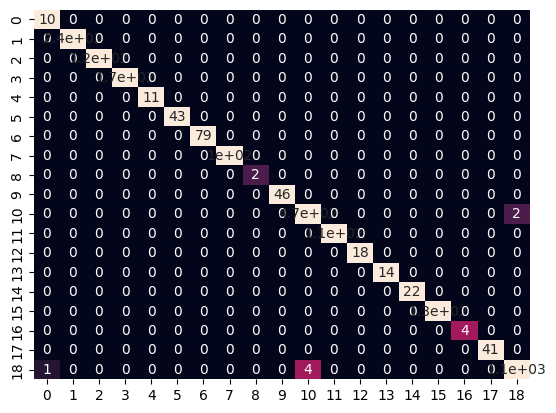

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(confusion_matrix(true, preds), annot=True, vmax = 10, vmin=0, cbar=False)
plt.show()

In [24]:
train['pred'] = preds
train['true'] = true

In [25]:
train.head()

,img_path,label,pred,true
963,data/train/훼손/1297.png,18,18,18
1043,data/train/훼손/1079.png,18,18,18
1442,data/train/훼손/828.png,18,18,18
1833,data/train/훼손/454.png,18,18,18
2886,data/train/오염/138.png,10,10,10


In [26]:
train['err'] = train['pred'] == train['label']

In [27]:
err_ds = train.loc[(train['err'] == False)].copy()

In [28]:
img_err = err_ds['img_path'].values

IndexError: ignored

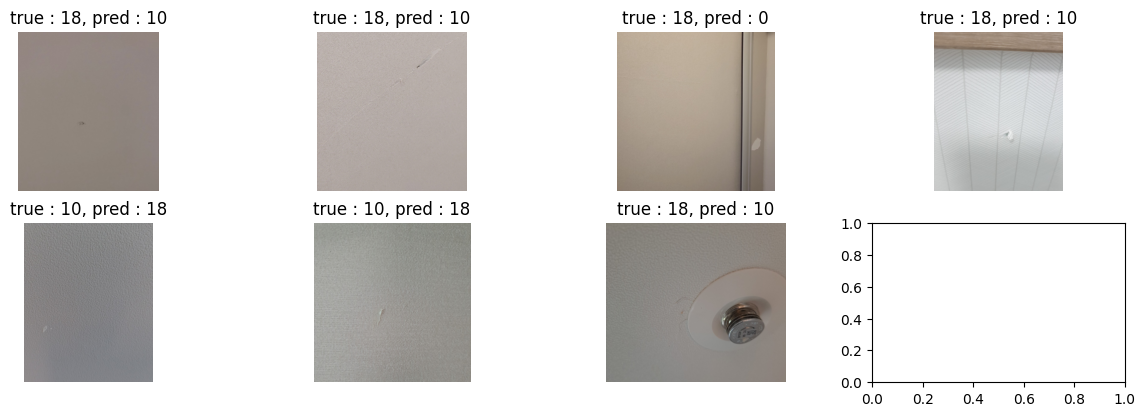

In [29]:
plt.figure(figsize=(15,12))
for i in range(20):
    plt.subplot(5,4,i+1)
    im = Image.open(err_ds['img_path'].values[i])
    plt.imshow(im)
    plt.axis('off')
    tr = err_ds['label'].values[i]
    pr = err_ds['pred'].values[i]
    plt.title(f'true : {tr}, pred : {pr}')
plt.tight_layout()
plt.show()

## **test**

In [34]:
#test
test = pd.read_csv('data/test.csv')

In [35]:
test.head()

,id,img_path
0,TEST_000,./test/000.png
1,TEST_001,./test/001.png
2,TEST_002,./test/002.png
3,TEST_003,./test/003.png
4,TEST_004,./test/004.png


In [36]:
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=2)

In [37]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(test_loader):
            imgs = imgs.float().to(device)
            
            pred = model(imgs)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
    
    #preds = le.inverse_transform(preds)
    return preds

In [38]:
preds = inference(infer_model, test_loader, device)

  0%|          | 0/23 [00:00<?, ?it/s]

## **submit**

In [39]:
submit = pd.read_csv('data/sample_submission.csv')

In [40]:
submit['label'] = preds

In [41]:
submit.loc[submit['label'] == 0, 'label'] = '가구수정'
submit.loc[submit['label'] == 1, 'label'] = '걸레받이수정'
submit.loc[submit['label'] == 2, 'label'] = '곰팡이'
submit.loc[submit['label'] == 3, 'label'] = '꼬임'
submit.loc[submit['label'] == 4, 'label'] = '녹오염'
submit.loc[submit['label'] == 5, 'label'] = '들뜸'
submit.loc[submit['label'] == 6, 'label'] = '면불량'
submit.loc[submit['label'] == 7, 'label'] = '몰딩수정'
submit.loc[submit['label'] == 8, 'label'] = '반점'
submit.loc[submit['label'] == 9, 'label'] = '석고수정'
submit.loc[submit['label'] == 10, 'label'] = '오염'
submit.loc[submit['label'] == 11, 'label'] = '오타공'
submit.loc[submit['label'] == 12, 'label'] = '울음'
submit.loc[submit['label'] == 13, 'label'] = '이음부불량'
submit.loc[submit['label'] == 14, 'label'] = '창틀,문틀수정'
submit.loc[submit['label'] == 15, 'label'] = '터짐'
submit.loc[submit['label'] == 16, 'label'] = '틈새과다'
submit.loc[submit['label'] == 17, 'label'] = '피스'
submit.loc[submit['label'] == 18, 'label'] = '훼손'

In [42]:
submit.head()

,id,label
0,TEST_000,훼손
1,TEST_001,오염
2,TEST_002,훼손
3,TEST_003,훼손
4,TEST_004,훼손


In [43]:
submit.to_csv('./ConvNeXtBase.csv', index=False)

In [ ]:
# 모델 save
PATH = 'model.pickle'
torch.save(model.state_dict(), PATH)